# Проект: оптимизация производственных расходов для металлургического комбината "Стальная птица".

**Описание проекта**: Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава.

**Цель проекта**: Построить модель, которая будет её предсказывать.

**Ход проекта**:
- [Загрузка данных и первичный осмотр](#upload)
- [Исследовательский анализ и предобработка данных](#prep)
- [Объединение данных](#merge)
- [Вторичный исследовательский анализ и предобработка данных](#prep2)
- [Корреляционный анализ объединенного датасета](#corr)
- [Подготовка данных к машинному обучению](#ml_prep)
- [Машинное обучение](#ml)
- [Анализ результатов и выбор лучшей модели](#best_model)
- [Итоговый вывод и рекомендация заказчику](#res)

<a id='upload'></a>
## Загрузка данных и первичный осмотр.

Импортируем все необходимые библиотеки, а также зададим нужные константы:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from IPython.display import display
!pip install phik -q
import phik
import warnings
!pip install shap -q
import shap

from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error


RANDOM_STATE = 171125
TEST_SIZE = 0.25

Напишем удобную функцию для подгрузки данных:

In [2]:
def upload_function(name, sep, dec):
    try:
        data = pd.read_csv(f'/datasets/{name}.csv', sep=sep, decimal=dec)
    except:
        data = pd.read_csv(f'https://code.s3.yandex.net/datasets/{name}.csv', sep=sep, decimal=dec)
    return data

Приступим к подгрузке данных:

In [3]:
data_arc_new = upload_function('data_arc_new', sep=',', dec=',')
data_bulk_new = upload_function('data_bulk_new', sep=',', dec=',')
data_bulk_time_new = upload_function('data_bulk_time_new', sep=',', dec=',')
data_gas_new = upload_function('data_gas_new', sep=',', dec=',')
data_temp_new = upload_function('data_temp_new', sep=',', dec=',')
data_wire_new = upload_function('data_wire_new', sep=',', dec=',')
data_wire_time_new = upload_function('data_wire_time_new', sep=',', dec=',')

In [4]:
datasets = {'data_arc_new': data_arc_new, 'data_bulk_new': data_bulk_new, 
            'data_bulk_time_new': data_bulk_time_new, 
            'data_gas_new': data_gas_new, 'data_temp_new': data_temp_new, 
           'data_wire_new': data_wire_new, 'data_wire_time_new': data_wire_time_new}

for name, dataset in datasets.items():
    print('Датасет:', name)
    display(dataset.head())

Датасет: data_arc_new


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.30513,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.43046
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Датасет: data_bulk_new


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Датасет: data_bulk_time_new


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


Датасет: data_gas_new


,key,Газ 1
0,1,29.7499859302
1,2,12.5555609779
2,3,28.5547926192
3,4,18.8412192323
4,5,5.4136918254


Датасет: data_temp_new


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Датасет: data_wire_new


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Датасет: data_wire_time_new


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


На первый взгляд, все не так плохо, по крайней мере, данные загрузились корректно. Посмотрим на каждый датасет более детально:

In [5]:
for name, dataset in datasets.items():
    print('Датасет:', name)
    print(dataset.info())
    print('/n/n')

Датасет: data_arc_new
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   key                   14876 non-null  int64 
 1   Начало нагрева дугой  14876 non-null  object
 2   Конец нагрева дугой   14876 non-null  object
 3   Активная мощность     14876 non-null  object
 4   Реактивная мощность   14876 non-null  object
dtypes: int64(1), object(4)
memory usage: 581.2+ KB
None
/n/n
Датасет: data_bulk_new
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    ob

Видно, что практически все числовые признаки имеют тип *object*. Также, в датасете *data_temp_new* в температуре присутствуют несколько тысяч пропусков. Все это будет рассмотрено и обработано более детально на следующем этапе проекта.

<a id='prep'></a>
## Предобработка данных и исследовательский анализ.

Для каждого датасета будем обрабатывать тип значений в признаках и параллельно проводить исследовательский анализ:

**Датасет *data_arc_new* (данные электродов)** :

In [6]:
data_arc_new = data_arc_new.rename(columns={'Начало нагрева дугой': 'start_time',
                                    'Конец нагрева дугой': 'end_time',
                                    'Активная мощность': 'active_power',
                                    'Реактивная мощность': 'reactive_power'})
data_arc_new['start_time'] = data_arc_new['start_time'].astype('datetime64[ns]')
data_arc_new['end_time'] = data_arc_new['end_time'].astype('datetime64[ns]')
data_arc_new['active_power'] = data_arc_new['active_power'].astype('float')
data_arc_new['reactive_power'] = data_arc_new['reactive_power'].astype('float') 

In [7]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   start_time      14876 non-null  datetime64[ns]
 2   end_time        14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


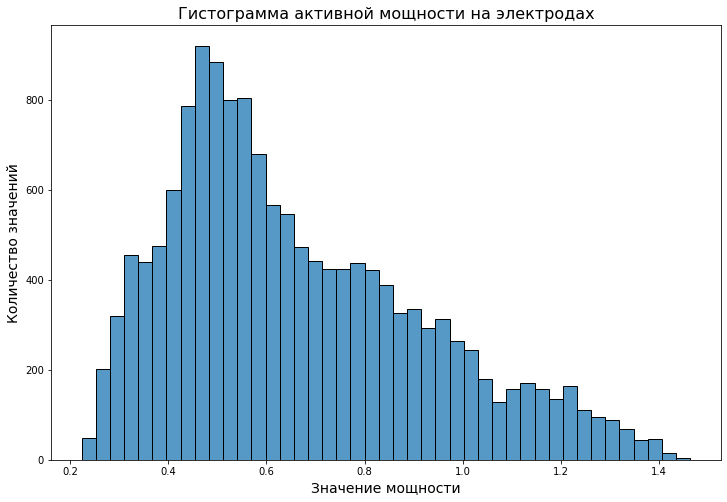

In [8]:
plt.figure(figsize=(12, 8))
sns.histplot(data=data_arc_new['active_power'])
plt.xlabel('Значение мощности', fontsize=14)
plt.ylabel('Количество значений', fontsize=14)
plt.title('Гистограмма активной мощности на электродах', fontsize=16);

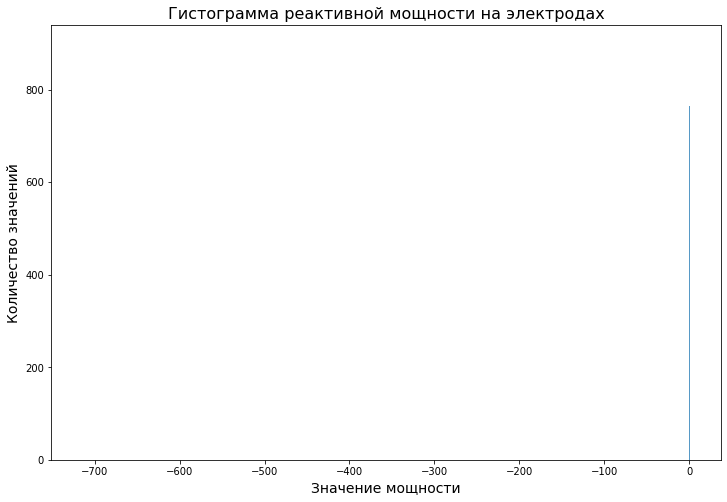

In [9]:
plt.figure(figsize=(12, 8))
sns.histplot(data=data_arc_new['reactive_power'])
plt.xlabel('Значение мощности', fontsize=14)
plt.ylabel('Количество значений', fontsize=14)
plt.title('Гистограмма реактивной мощности на электродах', fontsize=16);

In [10]:
data_arc_new['reactive_power'].describe()

count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: reactive_power, dtype: float64

Вот и первое аномальное значение - мощность *-715.48*, явно выбивающаяся из общей картины. Поменяем это значение на медианное:

In [11]:
data_arc_new[data_arc_new['reactive_power'] < 0] = data_arc_new['reactive_power'].median()

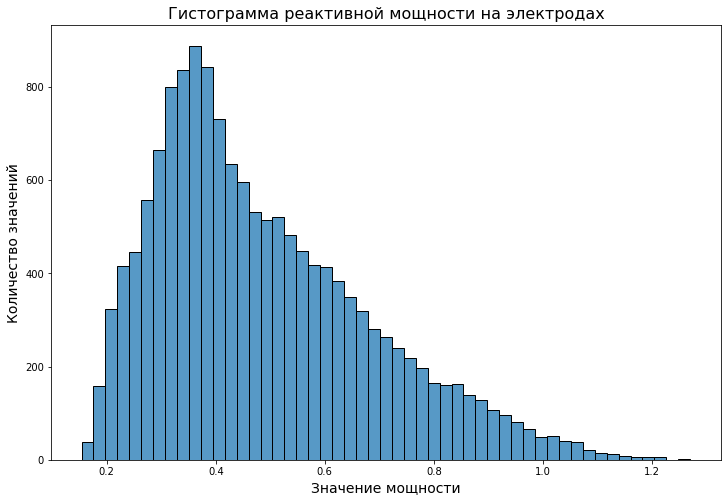

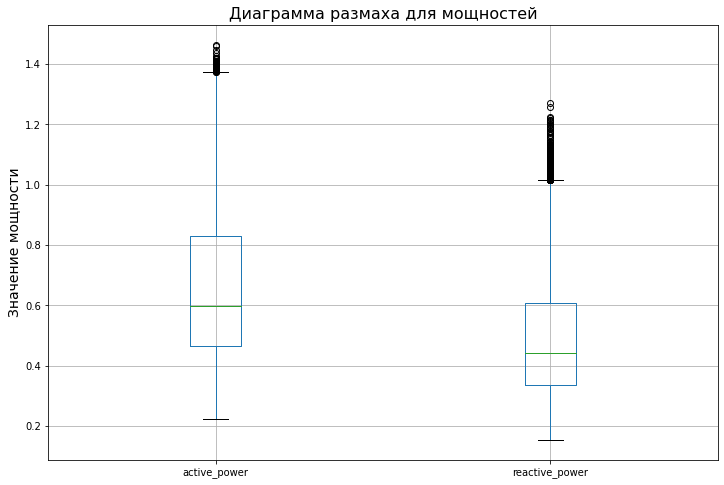

In [12]:
plt.figure(figsize=(12, 8))
sns.histplot(data=data_arc_new['reactive_power'])
plt.xlabel('Значение мощности', fontsize=14)
plt.ylabel('Количество значений', fontsize=14)
plt.title('Гистограмма реактивной мощности на электродах', fontsize=16)

plt.figure(figsize=(12, 8))
data_arc_new.drop('key', axis=1).boxplot()
plt.ylabel('Значение мощности', fontsize=14)
plt.title('Диаграмма размаха для мощностей', fontsize=16);

Теперь все в порядке. В остальном, ни на первой, ни на второй гистограммах, ничего особенного не замечено. Типы данных в признаках были приведены к соответствующим - формат даты и времени и не целочисленные значения типа *float*.

**Датасет *data_bulk_new* (объем подаваемого материала)** :

In [13]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [14]:
data_bulk_new

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [15]:
for i in data_bulk_new.drop('key', axis=1).columns:
    data_bulk_new[i] = pd.to_numeric(data_bulk_new[i], errors='coerce')
    
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [16]:
data_bulk_new

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


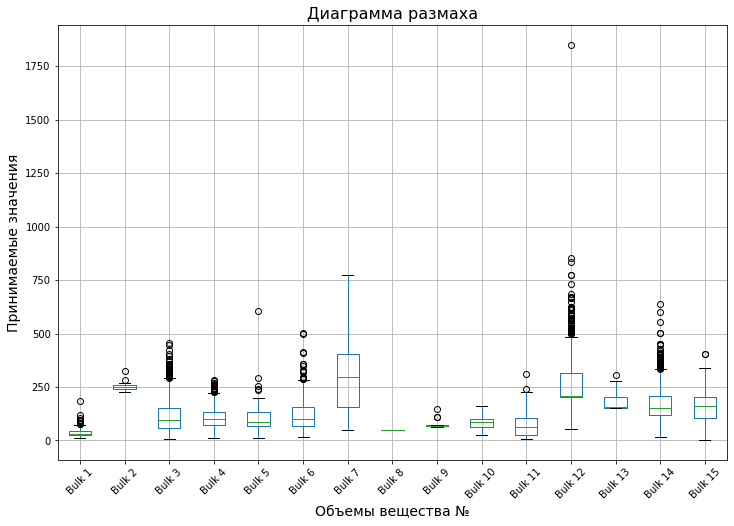

In [17]:
plt.figure(figsize=(12, 8))
data_bulk_new.drop('key', axis=1).boxplot()
plt.xlabel('Объемы вещества №', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Принимаемые значения', fontsize=14)
plt.title('Диаграмма размаха', fontsize=16);

Ничего необычного так же не замечено. Все объемы приведены к численному типу данных.

**Датасет *data_bulk_time_new* (время подачи соответствующих материалов)** :

In [18]:
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [19]:
for i in data_bulk_time_new.drop('key', axis=1).columns:
    data_bulk_time_new[i] = data_bulk_time_new.astype('datetime64[ns]')
    
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   3129 non-null   datetime64[ns]
 2   Bulk 2   3129 non-null   datetime64[ns]
 3   Bulk 3   3129 non-null   datetime64[ns]
 4   Bulk 4   3129 non-null   datetime64[ns]
 5   Bulk 5   3129 non-null   datetime64[ns]
 6   Bulk 6   3129 non-null   datetime64[ns]
 7   Bulk 7   3129 non-null   datetime64[ns]
 8   Bulk 8   3129 non-null   datetime64[ns]
 9   Bulk 9   3129 non-null   datetime64[ns]
 10  Bulk 10  3129 non-null   datetime64[ns]
 11  Bulk 11  3129 non-null   datetime64[ns]
 12  Bulk 12  3129 non-null   datetime64[ns]
 13  Bulk 13  3129 non-null   datetime64[ns]
 14  Bulk 14  3129 non-null   datetime64[ns]
 15  Bulk 15  3129 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


**Датасет *data_gas_new* (продувка сплава газом)** :

In [20]:
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3239 non-null   int64 
 1   Газ 1   3239 non-null   object
dtypes: int64(1), object(1)
memory usage: 50.7+ KB


In [21]:
data_gas_new = data_gas_new.rename(columns={'Газ 1': 'gas_1'})
data_gas_new['gas_1'] = data_gas_new['gas_1'].astype('float')

In [22]:
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


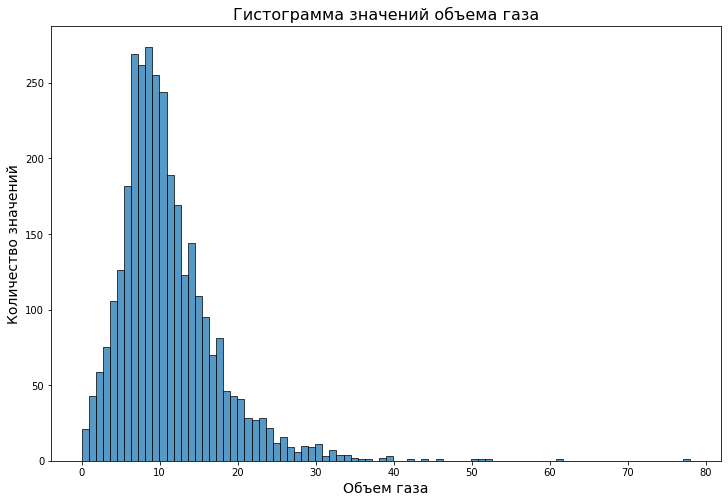

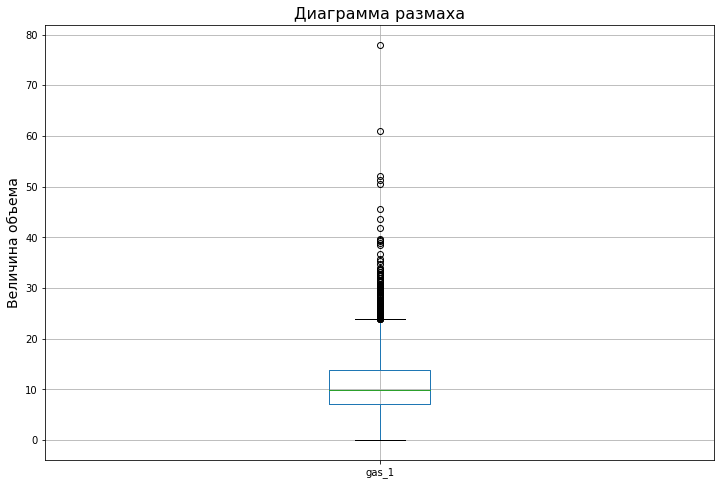

In [23]:
plt.figure(figsize=(12, 8))
sns.histplot(data=data_gas_new['gas_1'])
plt.xlabel('Объем газа', fontsize=14)
plt.ylabel('Количество значений', fontsize=14)
plt.title('Гистограмма значений объема газа', fontsize=16)

plt.figure(figsize=(12, 8))
data_gas_new.drop('key', axis=1).boxplot()
plt.ylabel('Величина объема', fontsize=14)
plt.title('Диаграмма размаха', fontsize=16);

Есть какое-то количество выбросов, зато аномальных значений нет. Столбец был перименован для более удобной работы, данные в нем приведены к численному типу данных.

**Датасет *data_temp_new* (результаты измерения температуры)** :

In [24]:
data_temp_new = data_temp_new.rename(columns={'Время замера': 'measure_time',
                                             'Температура': 'temperature'})

data_temp_new['measure_time'] = data_temp_new['measure_time'].astype('datetime64[ns]')
data_temp_new['temperature'] = data_temp_new['temperature'].astype('float')

In [25]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   measure_time  18092 non-null  datetime64[ns]
 2   temperature   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


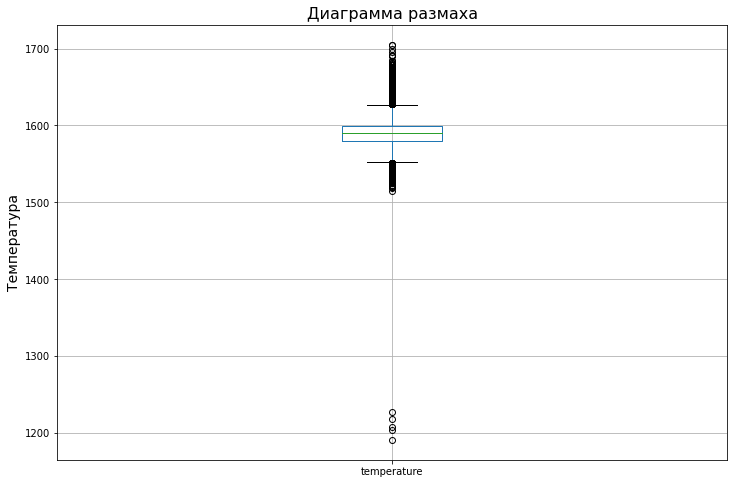

In [26]:
plt.figure(figsize=(12, 8))
data_temp_new.drop('key', axis=1).boxplot()
plt.ylabel('Температура', fontsize=14)
plt.title('Диаграмма размаха', fontsize=16);

Есть несколько аномальных случаев с температурой нижу 1300 градусов, удалим их:

In [27]:
data_temp_new = data_temp_new.loc[data_temp_new['temperature'] > 1300]

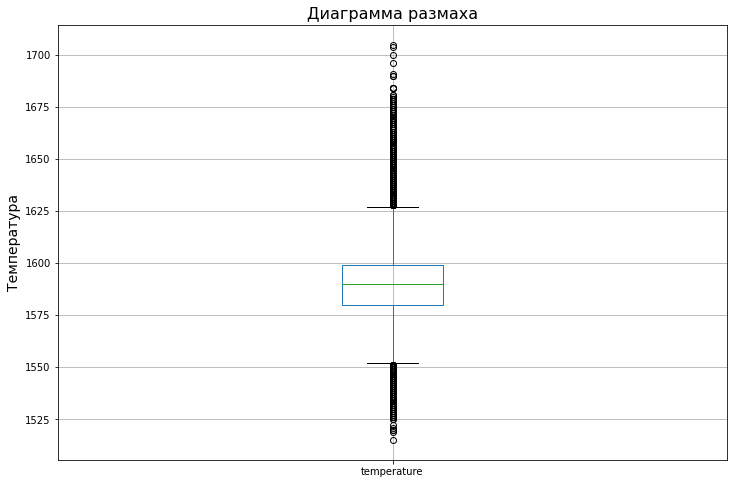

In [28]:
plt.figure(figsize=(12, 8))
data_temp_new.drop('key', axis=1).boxplot()
plt.ylabel('Температура', fontsize=14)
plt.title('Диаграмма размаха', fontsize=16);

In [29]:
data_temp_new = data_temp_new.groupby('key').filter(lambda x: x['temperature'].notna().sum() > 1)

**Датасет *data_wire_new* (объем подаваемых проволочных материалов)** :

In [30]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [31]:
for i in data_wire_new.drop('key', axis=1).columns:
    data_wire_new[i] = data_wire_new[i].astype('float')

data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


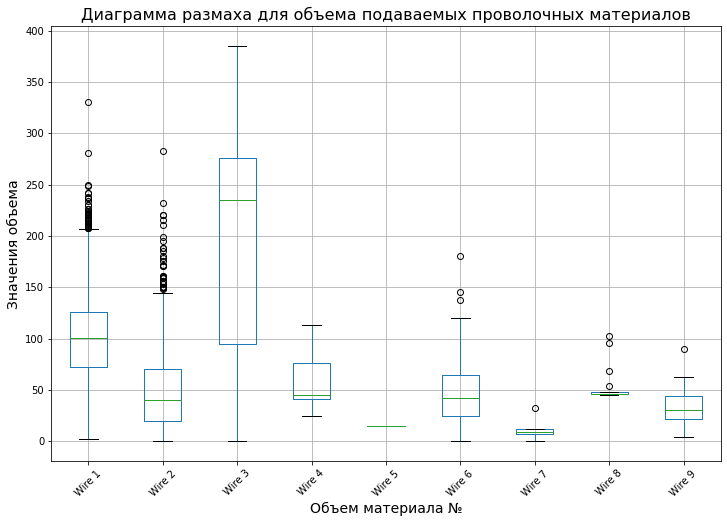

In [32]:
plt.figure(figsize=(12, 8))
data_wire_new.drop('key', axis=1).boxplot()
plt.xlabel('Объем материала №', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Значения объема', fontsize=14)
plt.title('Диаграмма размаха для объема подаваемых проволочных материалов', fontsize=16);

Аномальных значений не обнаружено, данные предобработаны аналогично предыдущим датасетам.

**Датасет *data_wire_time_new* (время подачи)** :

In [33]:
for i in data_wire_time_new.drop('key', axis=1).columns:
    data_wire_time_new[i] = data_wire_time_new[i].astype('datetime64[ns]')
    
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


Данные приведены к временному типу.

In [34]:
data_wire_time_new

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-09-06 11:33:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3077,3238,2019-09-06 12:18:35,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3078,3239,2019-09-06 14:36:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3079,3240,2019-09-06 15:33:55,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


**Промежуточные выводы**:

Датасеты были обработаны: признаки переименованы в соответствии с правилами оформления и приведены к соответствующим типам данных, убраны аномалии (таковыми оказались значения реактивной мощности и температуры, ниже 1300 градусов). Выбросов, если таковые наблюдаются, не так много. Распределения числовых признаков походят на нормальные.

Отберем нужные нам признаки для обучения моделей. Среди таких можно выделить:

Из датасета **data_arc_new** :
- Точно можно взять активную и реактивные мощности (*active_power, reactive_power*)
- А также время начала и конца нагрева, таким образом, из первого датасета можно и нужно взять всю информацию.

Датасет **data_bulk_new** : 
Возьмем объемы тех веществ, которые добавлялись чаще всего, среди таких:
- Bulk 1 (252 записи  из 3129 сущетсвующих)
- Bulk 3 (1298 записей)
- Bulk 4 (1014 записей)
- Bulk 6 (576 записей)
- Bulk 12 (2450 записей)
- Bulk 14 (2806 записей)
- Bulk 15 (2248 записей)
Остальные везества встречались менее чем в 200 случаях, то есть менее, чем в 6% от общей массы.

Датасет **data_bulk_time_new** : материалы подавались практически мгновенно, без длительности, поэтому ценности для исследования (конкретно с такими данными) время их подачи не несет.

Датасет **data_gas_new** : здесь все просто, берем всю информацию об объеме подаваемого газа.

Датасет **data_temp_new** : определенно, нужно брать известные значения температуры и соответствующее время. 

Датасет **data_wire_new** : ситуация с объемом проволочных материалов аналогична ситуации с сыпучими, посмотрим на самые частые добавки и выберем их:
- Wire 1 (3055 записей из 3081 всего)
- Wire 2 (1079 записей)

Датасет **data_wire_time_new** : аналогично сыпчатым материалам.

<a id='merge'></a>
## Объединение нужных нам признаков.

Объединим выделенные выше признаки, но сначала немного доработаем данные. Найдем время нагрева с помощью электродов и, в дальнейшем, будем агрегировать по сумме времени нагрева и мощностей. 

In [35]:
data_arc_new['heating_time'] = data_arc_new['end_time'] - data_arc_new['start_time']
data_arc_new.head()

,key,start_time,end_time,active_power,reactive_power,heating_time
0,1.0,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0 days 00:03:48
1,1.0,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0 days 00:03:05
2,1.0,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0 days 00:02:52
3,1.0,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0 days 00:06:05
4,1.0,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0 days 00:02:28


За основу будем брать датасет **data_temp_new** :

In [36]:
temp_sorted = data_temp_new.sort_values(['key', 'measure_time']) # сортируем, на всякий случай, значения


def get_prefinal(series):
    clean_series = series.dropna()
    if len(clean_series) >= 2:
        return clean_series.iloc[-2]  # предпоследний из НЕпропущенных
    elif len(clean_series) == 1:
        return clean_series.iloc[0]   # если один валидный замер
    else:
        return np.nan  # если вообще нет валидных замеров
    
    
data_final = temp_sorted.groupby('key').agg(
    initial_temp=('temperature', 'first'),
    prefinal_temp=('temperature', get_prefinal),
    final_temp=('temperature', 'last'),
    initial_time=('measure_time', 'first'),
    prefinal_time=('measure_time', get_prefinal),
    final_time=('measure_time', 'last')
).reset_index()  # начинаем формировать итоговый датасет с начальной, 
                # предпоследней и конечной температурой, а также временем замера

data_final['total_duration'] = data_final['final_time'] - data_final['initial_time']
data_final

,key,initial_temp,prefinal_temp,final_temp,initial_time,prefinal_time,final_time,total_duration
0,1,1571.0,1606.0,1613.0,2019-05-03 11:02:04,2019-05-03 11:25:59,2019-05-03 11:30:38,0 days 00:28:34
1,2,1581.0,1604.0,1602.0,2019-05-03 11:34:04,2019-05-03 11:49:38,2019-05-03 11:55:09,0 days 00:21:05
2,3,1596.0,1600.0,1599.0,2019-05-03 12:06:44,2019-05-03 12:31:04,2019-05-03 12:35:57,0 days 00:29:13
3,4,1601.0,1617.0,1625.0,2019-05-03 12:39:27,2019-05-03 12:53:02,2019-05-03 12:59:47,0 days 00:20:20
4,5,1576.0,1586.0,1602.0,2019-05-03 13:11:03,2019-05-03 13:32:34,2019-05-03 13:36:39,0 days 00:25:36
...,...,...,...,...,...,...,...,...
2470,2495,1570.0,1585.0,1591.0,2019-08-10 11:27:47,2019-08-10 11:46:16,2019-08-10 11:50:47,0 days 00:23:00
2471,2496,1554.0,1580.0,1591.0,2019-08-10 11:56:48,2019-08-10 12:19:09,2019-08-10 12:25:13,0 days 00:28:25
2472,2497,1571.0,1576.0,1589.0,2019-08-10 12:37:26,2019-08-10 12:47:44,2019-08-10 12:53:28,0 days 00:16:02
2473,2498,1591.0,1582.0,1594.0,2019-08-10 12:58:11,2019-08-10 13:20:08,2019-08-10 13:23:31,0 days 00:25:20


Базу итогового датасета сформировали, приступим к присоединению остальных признаков. Добавляем данные о нагреве дугой:

In [37]:
data_arc_new_agg = data_arc_new.groupby('key').agg({
    'active_power': 'sum',           # Суммарная активная мощность
    'reactive_power': 'sum',         # Суммарная реактивная мощность  
    'heating_time': 'sum',                # Общее время нагрева
    'start_time': 'min',        # Время первого нагрева
    'end_time': 'max',         # Время последнего нагрева
    'key': 'count'                        # Количество операций нагрева
}).rename(columns={'key': 'arc_operations_count'}).reset_index()

data_final = data_final.merge(data_arc_new_agg, on='key', how='inner')
data_final

/opt/conda/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


,key,initial_temp,prefinal_temp,final_temp,initial_time,prefinal_time,final_time,total_duration,active_power,reactive_power,heating_time,start_time,end_time,arc_operations_count
0,1,1571.0,1606.0,1613.0,2019-05-03 11:02:04,2019-05-03 11:25:59,2019-05-03 11:30:38,0 days 00:28:34,3.036730,2.142821,0 days 00:18:18,2019-05-03 11:02:14,2019-05-03 11:28:37,5
1,2,1581.0,1604.0,1602.0,2019-05-03 11:34:04,2019-05-03 11:49:38,2019-05-03 11:55:09,0 days 00:21:05,2.139408,1.453357,0 days 00:13:31,2019-05-03 11:34:14,2019-05-03 11:53:18,4
2,3,1596.0,1600.0,1599.0,2019-05-03 12:06:44,2019-05-03 12:31:04,2019-05-03 12:35:57,0 days 00:29:13,4.063641,2.937457,0 days 00:10:55,2019-05-03 12:06:54,2019-05-03 12:32:19,5
3,4,1601.0,1617.0,1625.0,2019-05-03 12:39:27,2019-05-03 12:53:02,2019-05-03 12:59:47,0 days 00:20:20,2.706489,2.056992,0 days 00:12:21,2019-05-03 12:39:37,2019-05-03 12:57:50,4
4,5,1576.0,1586.0,1602.0,2019-05-03 13:11:03,2019-05-03 13:32:34,2019-05-03 13:36:39,0 days 00:25:36,2.252950,1.687991,0 days 00:14:29,2019-05-03 13:11:13,2019-05-03 13:33:55,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,2495,1570.0,1585.0,1591.0,2019-08-10 11:27:47,2019-08-10 11:46:16,2019-08-10 11:50:47,0 days 00:23:00,3.168133,2.210936,0 days 00:12:03,2019-08-10 11:27:57,2019-08-10 11:48:05,4
2471,2496,1554.0,1580.0,1591.0,2019-08-10 11:56:48,2019-08-10 12:19:09,2019-08-10 12:25:13,0 days 00:28:25,4.174918,2.872031,0 days 00:15:40,2019-08-10 11:56:58,2019-08-10 12:23:07,6
2472,2497,1571.0,1576.0,1589.0,2019-08-10 12:37:26,2019-08-10 12:47:44,2019-08-10 12:53:28,0 days 00:16:02,3.605239,2.452092,0 days 00:09:29,2019-08-10 12:37:36,2019-08-10 12:51:20,3
2473,2498,1591.0,1582.0,1594.0,2019-08-10 12:58:11,2019-08-10 13:20:08,2019-08-10 13:23:31,0 days 00:25:20,3.202310,2.239820,0 days 00:12:30,2019-08-10 12:58:21,2019-08-10 13:20:59,5


Добавляем данные о сыпучих материалах (объем и время):

In [38]:
data_bulk_new

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [39]:
data_arc_new.merge(data_bulk_new, on='key', how='inner')

/opt/conda/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1141: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


,key,start_time,end_time,active_power,reactive_power,heating_time,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1.0,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0 days 00:03:48,NaN,NaN,NaN,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,1.0,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0 days 00:03:05,NaN,NaN,NaN,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
2,1.0,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0 days 00:02:52,NaN,NaN,NaN,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
3,1.0,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0 days 00:06:05,NaN,NaN,NaN,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
4,1.0,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0 days 00:02:28,NaN,NaN,NaN,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14595,3241.0,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,0 days 00:02:37,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0
14596,3241.0,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,0 days 00:03:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0
14597,3241.0,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,0 days 00:03:04,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0
14598,3241.0,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,0 days 00:00:57,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


In [40]:
data_bulk_new.columns

Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')

In [41]:
bulk_columns = ['key', 'Bulk 1', 'Bulk 3', 'Bulk 4', 'Bulk 6', 'Bulk 12', 'Bulk 14', 'Bulk 15']
data_final = data_final.merge(data_bulk_new[bulk_columns], on='key', how='inner') # объемы

In [42]:
data_final

,key,initial_temp,prefinal_temp,final_temp,initial_time,prefinal_time,final_time,total_duration,active_power,reactive_power,...,start_time,end_time,arc_operations_count,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15
0,1,1571.0,1606.0,1613.0,2019-05-03 11:02:04,2019-05-03 11:25:59,2019-05-03 11:30:38,0 days 00:28:34,3.036730,2.142821,...,2019-05-03 11:02:14,2019-05-03 11:28:37,5,NaN,NaN,43.0,NaN,206.0,150.0,154.0
1,2,1581.0,1604.0,1602.0,2019-05-03 11:34:04,2019-05-03 11:49:38,2019-05-03 11:55:09,0 days 00:21:05,2.139408,1.453357,...,2019-05-03 11:34:14,2019-05-03 11:53:18,4,NaN,NaN,73.0,NaN,206.0,149.0,154.0
2,3,1596.0,1600.0,1599.0,2019-05-03 12:06:44,2019-05-03 12:31:04,2019-05-03 12:35:57,0 days 00:29:13,4.063641,2.937457,...,2019-05-03 12:06:54,2019-05-03 12:32:19,5,NaN,NaN,34.0,NaN,205.0,152.0,153.0
3,4,1601.0,1617.0,1625.0,2019-05-03 12:39:27,2019-05-03 12:53:02,2019-05-03 12:59:47,0 days 00:20:20,2.706489,2.056992,...,2019-05-03 12:39:37,2019-05-03 12:57:50,4,NaN,NaN,81.0,NaN,207.0,153.0,154.0
4,5,1576.0,1586.0,1602.0,2019-05-03 13:11:03,2019-05-03 13:32:34,2019-05-03 13:36:39,0 days 00:25:36,2.252950,1.687991,...,2019-05-03 13:11:13,2019-05-03 13:33:55,4,NaN,NaN,78.0,NaN,203.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2402,2495,1570.0,1585.0,1591.0,2019-08-10 11:27:47,2019-08-10 11:46:16,2019-08-10 11:50:47,0 days 00:23:00,3.168133,2.210936,...,2019-08-10 11:27:57,2019-08-10 11:48:05,4,NaN,21.0,NaN,NaN,256.0,129.0,223.0
2403,2496,1554.0,1580.0,1591.0,2019-08-10 11:56:48,2019-08-10 12:19:09,2019-08-10 12:25:13,0 days 00:28:25,4.174918,2.872031,...,2019-08-10 11:56:58,2019-08-10 12:23:07,6,NaN,NaN,63.0,NaN,256.0,129.0,226.0
2404,2497,1571.0,1576.0,1589.0,2019-08-10 12:37:26,2019-08-10 12:47:44,2019-08-10 12:53:28,0 days 00:16:02,3.605239,2.452092,...,2019-08-10 12:37:36,2019-08-10 12:51:20,3,NaN,NaN,85.0,NaN,230.0,124.0,226.0
2405,2498,1591.0,1582.0,1594.0,2019-08-10 12:58:11,2019-08-10 13:20:08,2019-08-10 13:23:31,0 days 00:25:20,3.202310,2.239820,...,2019-08-10 12:58:21,2019-08-10 13:20:59,5,NaN,90.0,NaN,NaN,206.0,129.0,207.0


Добавляем газ:

In [43]:
data_final = data_final.merge(data_gas_new[['key', 'gas_1']], on='key', how='inner')

Добавляем проволочные материалы:

In [44]:
wire_columns = ['key', 'Wire 1', 'Wire 2']
data_final = data_final.merge(data_wire_new[wire_columns], on='key', how='inner')

Получили итоговый датасет со всеми нужными нам признаками:

In [45]:
display(data_final)

,key,initial_temp,prefinal_temp,final_temp,initial_time,prefinal_time,final_time,total_duration,active_power,reactive_power,...,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,gas_1,Wire 1,Wire 2
0,1,1571.0,1606.0,1613.0,2019-05-03 11:02:04,2019-05-03 11:25:59,2019-05-03 11:30:38,0 days 00:28:34,3.036730,2.142821,...,NaN,NaN,43.0,NaN,206.0,150.0,154.0,29.749986,60.059998,NaN
1,2,1581.0,1604.0,1602.0,2019-05-03 11:34:04,2019-05-03 11:49:38,2019-05-03 11:55:09,0 days 00:21:05,2.139408,1.453357,...,NaN,NaN,73.0,NaN,206.0,149.0,154.0,12.555561,96.052315,NaN
2,3,1596.0,1600.0,1599.0,2019-05-03 12:06:44,2019-05-03 12:31:04,2019-05-03 12:35:57,0 days 00:29:13,4.063641,2.937457,...,NaN,NaN,34.0,NaN,205.0,152.0,153.0,28.554793,91.160157,NaN
3,4,1601.0,1617.0,1625.0,2019-05-03 12:39:27,2019-05-03 12:53:02,2019-05-03 12:59:47,0 days 00:20:20,2.706489,2.056992,...,NaN,NaN,81.0,NaN,207.0,153.0,154.0,18.841219,89.063515,NaN
4,5,1576.0,1586.0,1602.0,2019-05-03 13:11:03,2019-05-03 13:32:34,2019-05-03 13:36:39,0 days 00:25:36,2.252950,1.687991,...,NaN,NaN,78.0,NaN,203.0,151.0,152.0,5.413692,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1570.0,1585.0,1591.0,2019-08-10 11:27:47,2019-08-10 11:46:16,2019-08-10 11:50:47,0 days 00:23:00,3.168133,2.210936,...,NaN,21.0,NaN,NaN,256.0,129.0,223.0,7.125735,89.150879,NaN
2325,2496,1554.0,1580.0,1591.0,2019-08-10 11:56:48,2019-08-10 12:19:09,2019-08-10 12:25:13,0 days 00:28:25,4.174918,2.872031,...,NaN,NaN,63.0,NaN,256.0,129.0,226.0,9.412616,114.179527,NaN
2326,2497,1571.0,1576.0,1589.0,2019-08-10 12:37:26,2019-08-10 12:47:44,2019-08-10 12:53:28,0 days 00:16:02,3.605239,2.452092,...,NaN,NaN,85.0,NaN,230.0,124.0,226.0,6.271699,94.086723,9.04800
2327,2498,1591.0,1582.0,1594.0,2019-08-10 12:58:11,2019-08-10 13:20:08,2019-08-10 13:23:31,0 days 00:25:20,3.202310,2.239820,...,NaN,90.0,NaN,NaN,206.0,129.0,207.0,14.953657,118.110717,NaN


In [46]:
data_final.columns

Index(['key', 'initial_temp', 'prefinal_temp', 'final_temp', 'initial_time',
       'prefinal_time', 'final_time', 'total_duration', 'active_power',
       'reactive_power', 'heating_time', 'start_time', 'end_time',
       'arc_operations_count', 'Bulk 1', 'Bulk 3', 'Bulk 4', 'Bulk 6',
       'Bulk 12', 'Bulk 14', 'Bulk 15', 'gas_1', 'Wire 1', 'Wire 2'],
      dtype='object')

In [47]:
data_final.shape

(2329, 24)

Итого 24 признака для каждой партии, финальный датасет готов. Приступим к его анализу.

<a id='prep2'></a>
## Анализ объединенного датасета.

Проведем исследовательский анализ итогового датасета. Все признаки в нем - числовые или временные. Для числовых еще раз построим гистограммы и диаграммы размаха. Переведем конечные временные признаки к секундам:

In [48]:
data_final['heating_time'] = pd.to_timedelta(data_final['heating_time'])
data_final['heating_time'] = data_final['heating_time'].dt.total_seconds()
data_final['total_duration'] = data_final['total_duration'].dt.total_seconds()

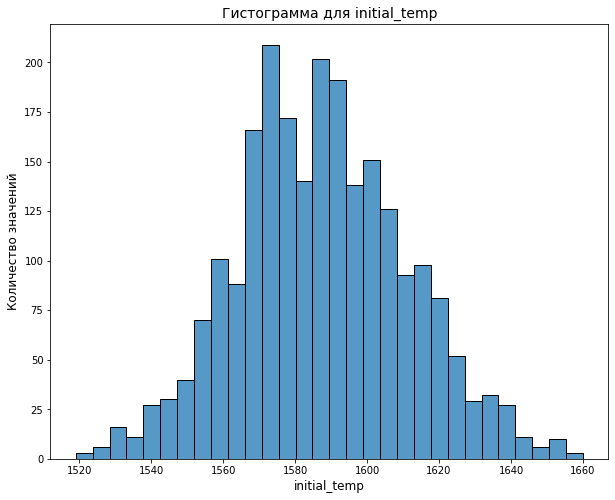

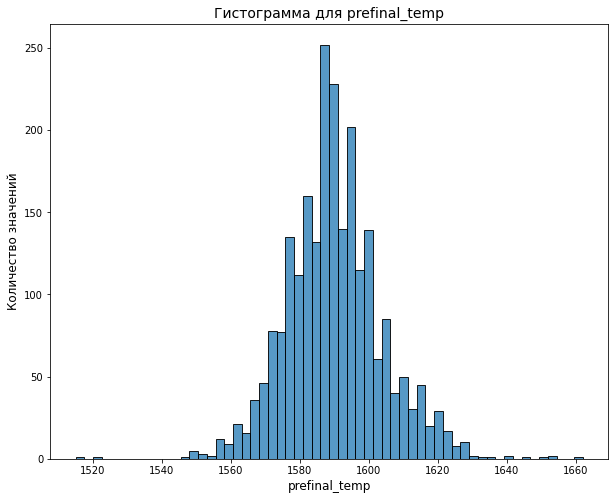

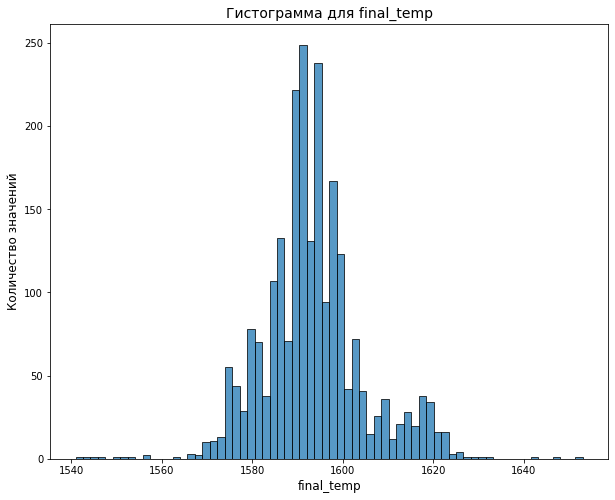

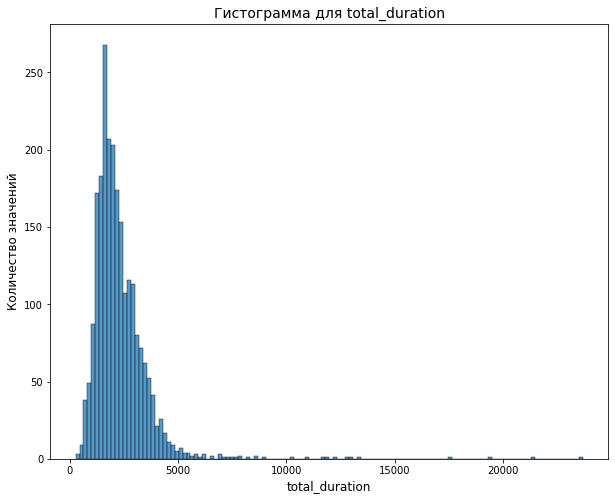

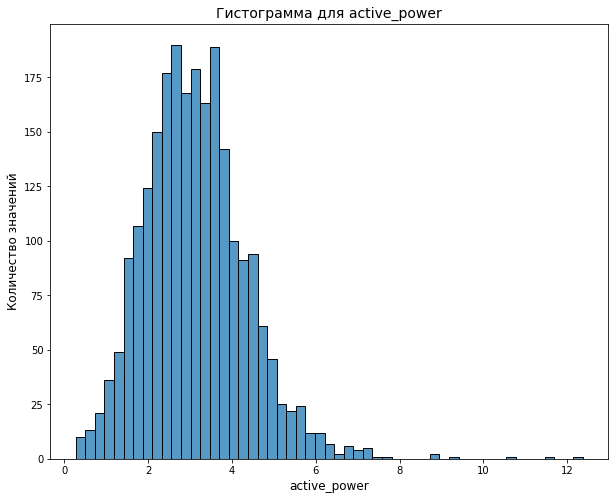

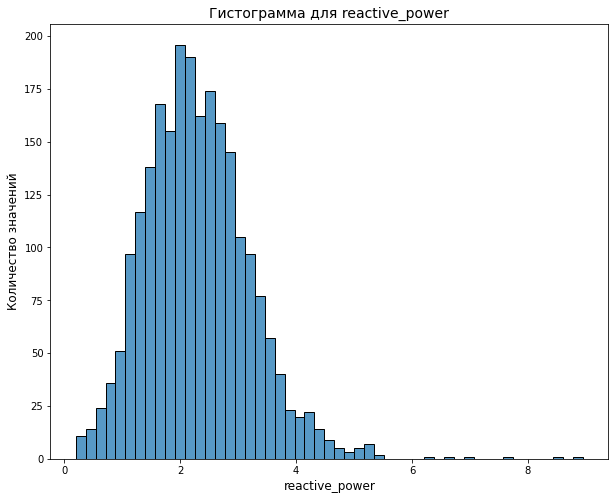

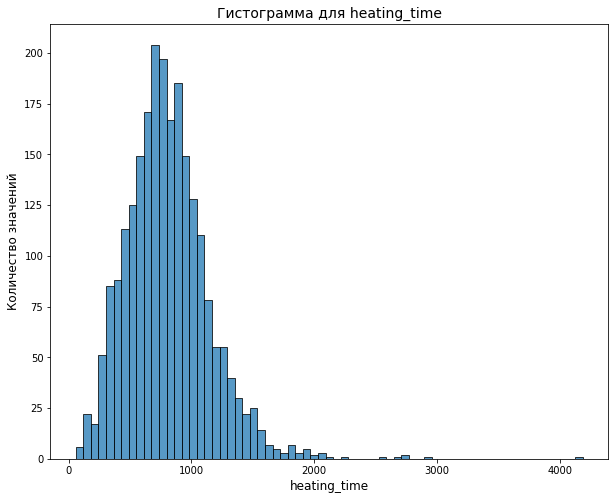

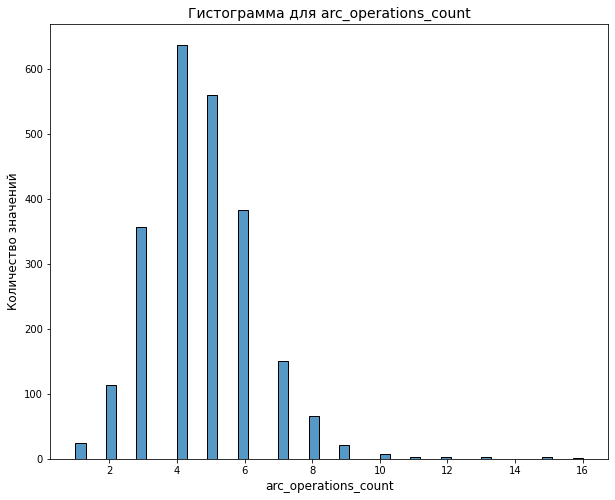

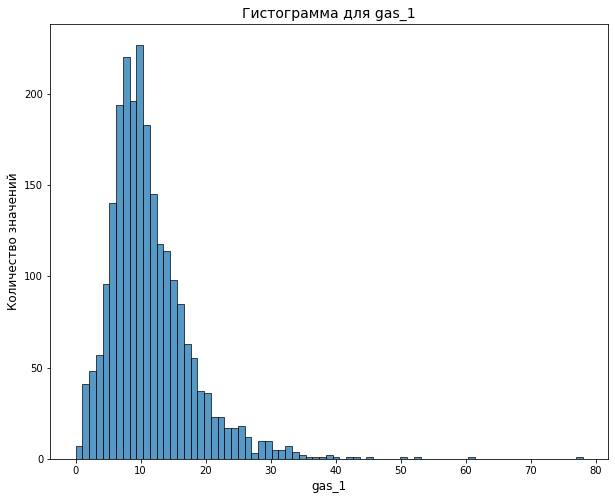

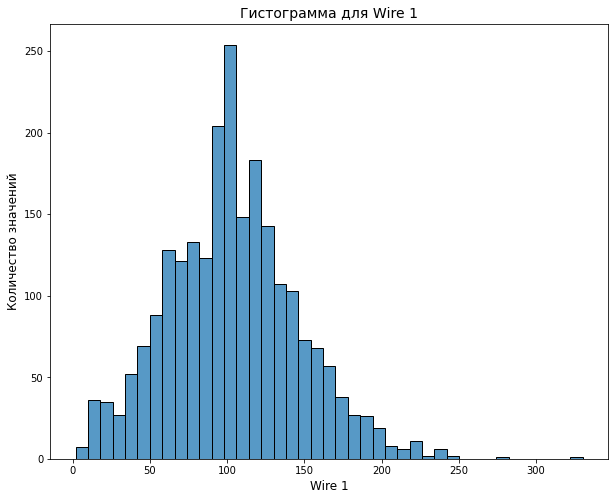

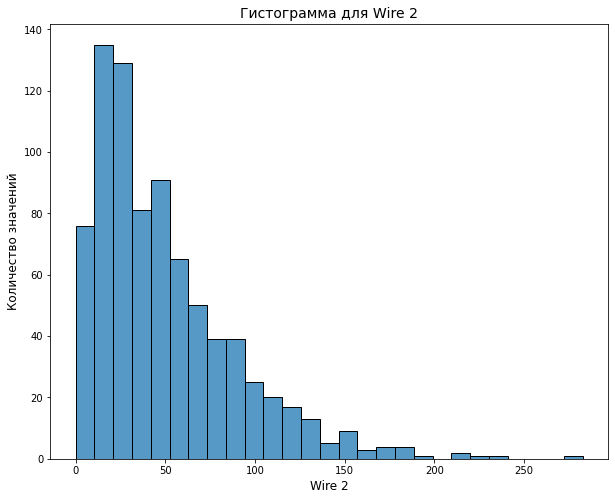

In [49]:
num_columns = ['initial_temp', 'prefinal_temp', 'final_temp', 'total_duration', 'active_power',
       'reactive_power', 'heating_time', 'arc_operations_count', 'gas_1',
       'Wire 1', 'Wire 2']

for col in num_columns:
    plt.figure(figsize=(10,8))
    sns.histplot(data=data_final[col])
    plt.title(f'Гистограмма для {col}', fontsize=14)
    plt.ylabel('Количество значений', fontsize=12)
    plt.xlabel(f'{col}', fontsize=12)
    plt.show()

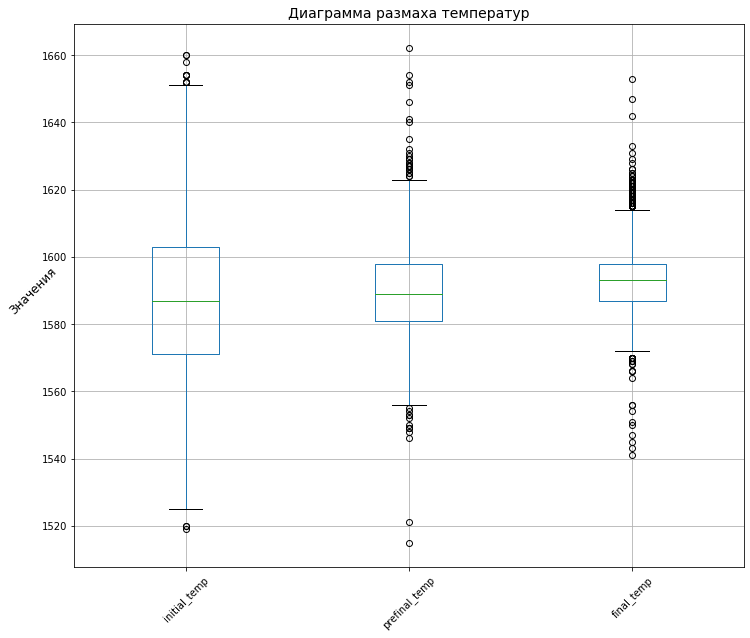

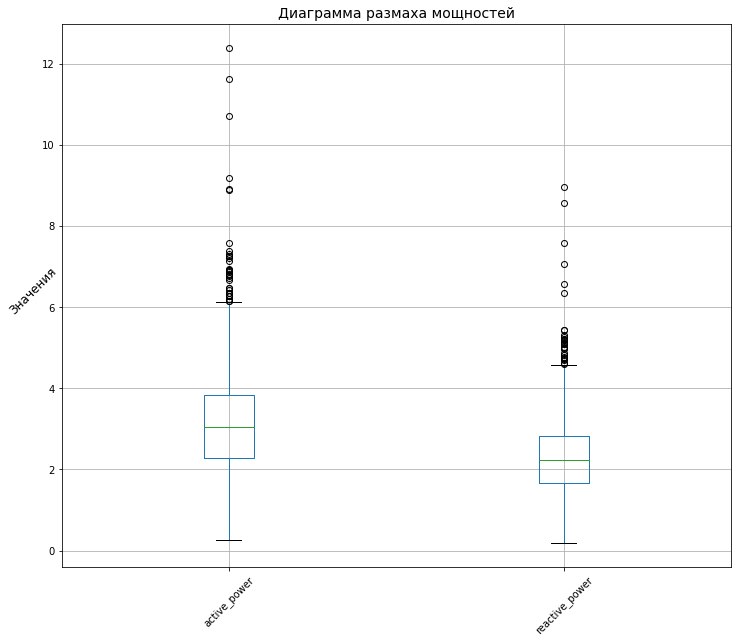

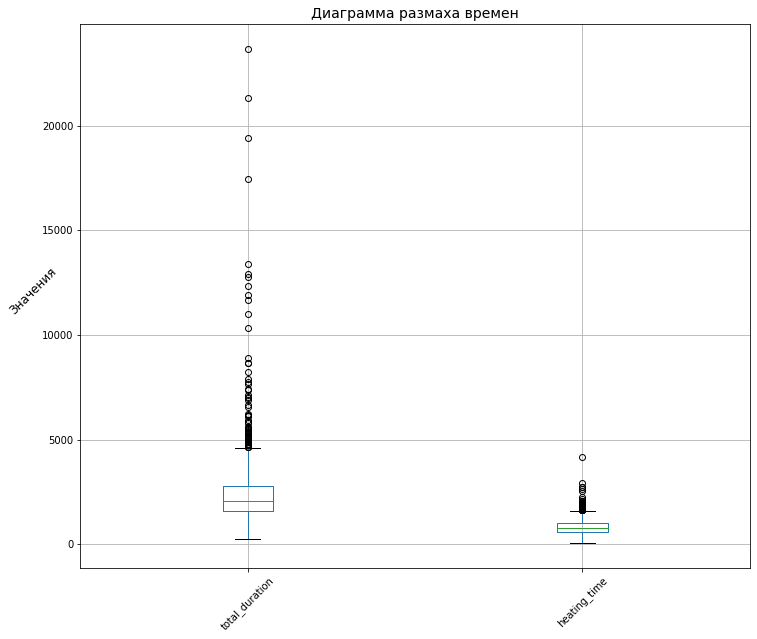

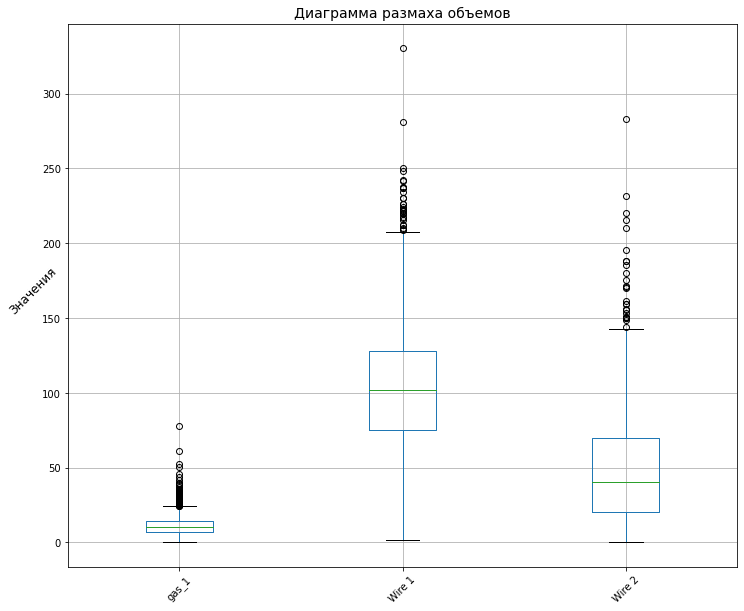

In [50]:
plt.figure(figsize=(12,10))
data_final[['initial_temp', 'prefinal_temp', 'final_temp']].boxplot()
plt.title('Диаграмма размаха температур', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Значения', fontsize=12, rotation=45)
plt.show()

plt.figure(figsize=(12,10))
data_final[['active_power', 'reactive_power']].boxplot()
plt.title('Диаграмма размаха мощностей', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Значения', fontsize=12, rotation=45)
plt.show()

plt.figure(figsize=(12,10))
data_final[['total_duration', 'heating_time']].boxplot()
plt.title('Диаграмма размаха времен', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Значения', fontsize=12, rotation=45)
plt.show()

plt.figure(figsize=(12,10))
data_final[['gas_1', 'Wire 1', 'Wire 2']].boxplot()
plt.title('Диаграмма размаха объемов', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Значения', fontsize=12, rotation=45)
plt.show()

**Промежуточные выводы** : Распределения каждого из признаков хорошие, выбросов мало. Относительно большое количество таковых наблюдается в полном времени цикла, в остальном, с данными все в порядке. Посмотрим, что покажет корреляционный анализ.



<a id='corr'></a>
## Корреляционный анализ.

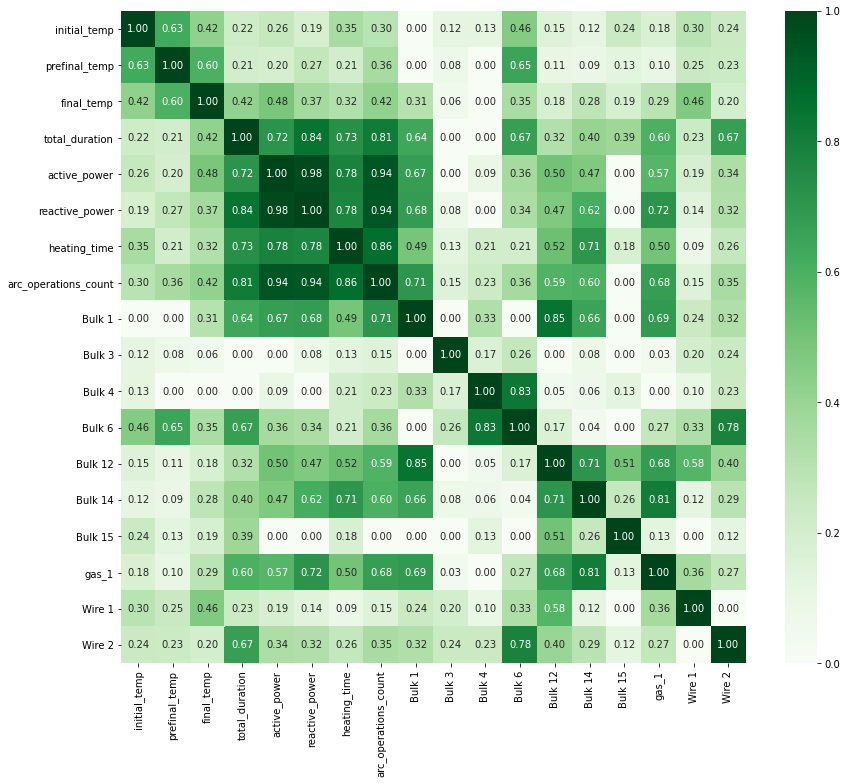

In [51]:
plt.figure(figsize=(14,12))
sns.heatmap(data_final.drop(['key', 'initial_time',
                             'prefinal_time', 'final_time',
                            'start_time', 'end_time'], axis=1).phik_matrix(interval_cols=['initial_temp', 'prefinal_temp', 
                                                                                          'final_temp', 
                                                                       'total_duration', 'active_power', 'reactive_power', 
                                                                        'heating_time', 'Bulk 1', 
                                                                        'Bulk 3', 'Bulk 4', 
                                                                        'Bulk 6', 'Bulk 12', 
                                                                        'Bulk 14', 'Bulk 15',
                                                                       'gas_1', 'Wire 1', 'Wire 2']),
           annot=True,
           fmt='.2f',
           cmap='Greens');

Слишком сильно (>0.95) зависимы друг от друга:
- Активная и реактивная мощности. Оставим только активную, она более значима в физическом смысле для нагрева.
- Также удалим количество итераций нагрева.

In [52]:
data_final = data_final.drop(['reactive_power', 'arc_operations_count'], axis=1)

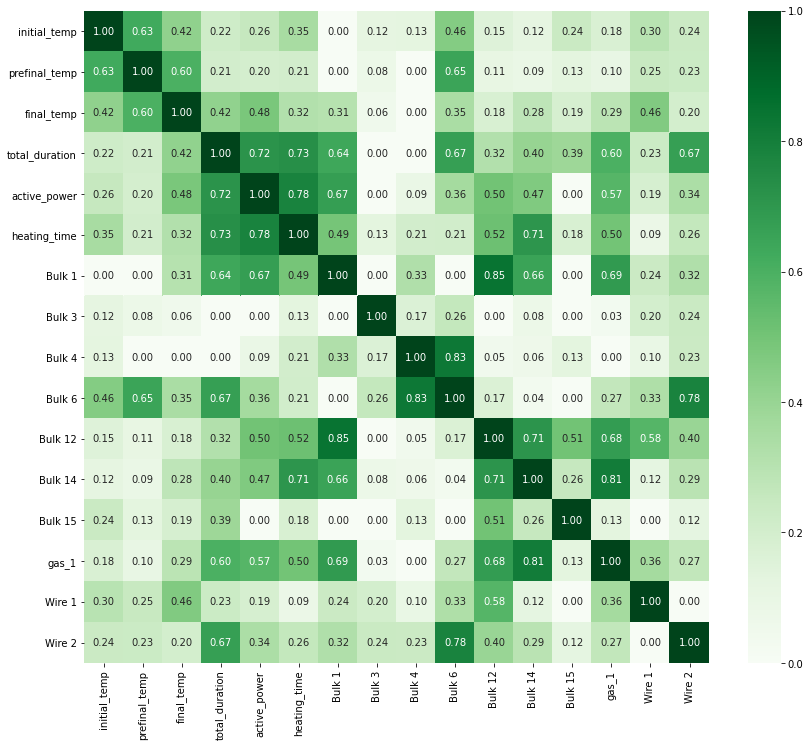

In [53]:
plt.figure(figsize=(14,12))
sns.heatmap(data_final.drop(['key', 'initial_time',
                             'prefinal_time', 'final_time',
                            'start_time', 'end_time'], axis=1).phik_matrix(interval_cols=['initial_temp', 'prefinal_temp', 
                                                                                          'final_temp', 
                                                                       'total_duration', 'active_power',  
                                                                        'heating_time', 'Bulk 1', 
                                                                        'Bulk 3', 'Bulk 4', 
                                                                        'Bulk 6', 'Bulk 12', 
                                                                        'Bulk 14', 'Bulk 15',
                                                                       'gas_1', 'Wire 1', 'Wire 2']),
           annot=True,
           fmt='.2f',
           cmap='Greens');

Так-то лучше. Признаков стало меньше, но теперь нет такой сильной мультиколлинеарности. Исключение составляет температура перед финальным замером, но она, что логично, и должна быть близкой к финальной. Приступим к подготовке данных к машиннмоу обучению, но сначала удалим все абсолютные времена из датасета:

In [54]:
data_final = data_final.drop(['initial_time', 'prefinal_time', 'final_time', 'start_time', 'end_time'], axis=1)

In [55]:
pd.set_option('display.max_columns', None)
display(data_final)

,key,initial_temp,prefinal_temp,final_temp,total_duration,active_power,heating_time,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,gas_1,Wire 1,Wire 2
0,1,1571.0,1606.0,1613.0,1714.0,3.036730,1098.0,NaN,NaN,43.0,NaN,206.0,150.0,154.0,29.749986,60.059998,NaN
1,2,1581.0,1604.0,1602.0,1265.0,2.139408,811.0,NaN,NaN,73.0,NaN,206.0,149.0,154.0,12.555561,96.052315,NaN
2,3,1596.0,1600.0,1599.0,1753.0,4.063641,655.0,NaN,NaN,34.0,NaN,205.0,152.0,153.0,28.554793,91.160157,NaN
3,4,1601.0,1617.0,1625.0,1220.0,2.706489,741.0,NaN,NaN,81.0,NaN,207.0,153.0,154.0,18.841219,89.063515,NaN
4,5,1576.0,1586.0,1602.0,1536.0,2.252950,869.0,NaN,NaN,78.0,NaN,203.0,151.0,152.0,5.413692,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1570.0,1585.0,1591.0,1380.0,3.168133,723.0,NaN,21.0,NaN,NaN,256.0,129.0,223.0,7.125735,89.150879,NaN
2325,2496,1554.0,1580.0,1591.0,1705.0,4.174918,940.0,NaN,NaN,63.0,NaN,256.0,129.0,226.0,9.412616,114.179527,NaN
2326,2497,1571.0,1576.0,1589.0,962.0,3.605239,569.0,NaN,NaN,85.0,NaN,230.0,124.0,226.0,6.271699,94.086723,9.04800
2327,2498,1591.0,1582.0,1594.0,1520.0,3.202310,750.0,NaN,90.0,NaN,NaN,206.0,129.0,207.0,14.953657,118.110717,NaN


<a id='ml_prep'></a>
## Подготовка данных к машинному обучению.

Разделим датасет на выборки:

In [56]:
X = data_final.drop(['key', 'final_temp'], axis=1)
y = data_final['final_temp']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=TEST_SIZE)

Сделаем пайплайн по подготовке данных. Все признаки числовые, кодировать их будем с помощью *StandardScaler*, так как он устойчив к выбросам, которые в наших данных присутствуют.

In [57]:
data_preprocessor = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value=0)),
    ('num', StandardScaler())
])

Будем пробовать две модели: одну линейную - *Ridge*, как более устойчивую к мультиколлинеарности модель, вторую - бустинга, *CatBoostingRegressor*, как модель, выигрывающую в скорости среди других подобных.

In [58]:
ridge_pipe = Pipeline([
    ('prep', data_preprocessor),
    ('models', Ridge(alpha=1, fit_intercept=True, random_state=RANDOM_STATE))
])

catboost_pipe = Pipeline([
    ('prep', data_preprocessor),
    ('models', CatBoostRegressor(verbose=False, random_state=RANDOM_STATE))
])

Еще сделаем словарики с гиперпараметрами, которые будем перебирать у моделей:

In [59]:
ridge_params = {
    'models__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'models__solver': ['auto', 'svd', 'cholesky', 'lsqr']
}

cat_params = {
    'models__iterations': range(100,400),
    'models__depth': range(1,51),
    'models__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'models__l2_leaf_reg': range(1,10)
}

Итоговые модели:

In [60]:
ridge_model = RandomizedSearchCV(ridge_pipe,
                                ridge_params,
                                cv=5,
                                n_jobs=-1,
                                scoring='neg_mean_absolute_error',
                                n_iter=24,
                                random_state=RANDOM_STATE)

catboost_model = RandomizedSearchCV(catboost_pipe,
                                   cat_params,
                                   cv=5,
                                    n_jobs=-1,
                                    scoring='neg_mean_absolute_error',
                                    random_state=RANDOM_STATE)

Все готово, чтобы начать обучение моделей и поиск оптимальных гиперпараметров. Приступим.

<a id='ml'></a>
## Машинное обучение моделей.

Начнем с линейной модели:

In [61]:
ridge_model.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('prep',
                                              Pipeline(steps=[('imp',
                                                               SimpleImputer(fill_value=0,
                                                                             strategy='constant')),
                                                              ('num',
                                                               StandardScaler())])),
                                             ('models',
                                              Ridge(alpha=1,
                                                    random_state=171125))]),
                   n_iter=24, n_jobs=-1,
                   param_distributions={'models__alpha': [0.001, 0.01, 0.1, 1,
                                                          10, 100],
                                        'models__solver': ['auto', 'svd',
                                                 

In [62]:
print('Гиперпараметры модели Ridge:', ridge_model.best_params_)
print('Лучшая метрика MAE, полученная на кросс-валидации:', round(-ridge_model.best_score_, 3))

Гиперпараметры модели Ridge: {'models__solver': 'auto', 'models__alpha': 1}
Лучшая метрика MAE, полученная на кросс-валидации: 4.617


Отличный результат у линейной модели. Неоспоримым ее преимуществом является то, что она простая, в следствие чего обучается быстро. Посмотрим на модель бустинга:

In [63]:
warnings.filterwarnings('ignore')

catboost_model.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('prep',
                                              Pipeline(steps=[('imp',
                                                               SimpleImputer(fill_value=0,
                                                                             strategy='constant')),
                                                              ('num',
                                                               StandardScaler())])),
                                             ('models',
                                              <catboost.core.CatBoostRegressor object at 0x7fcc5abf1760>)]),
                   n_jobs=-1,
                   param_distributions={'models__depth': range(1, 51),
                                        'models__iterations': range(100, 400),
                                        'models__l2_leaf_reg': range(1, 10),
                                        'models__learning_rate': [0.001, 0.01,
    

In [64]:
print('Гиперпараметры модели Ridge:', catboost_model.best_params_)
print('Лучшая метрика MAE, полученная на кросс-валидации:', round(-catboost_model.best_score_, 3))

Гиперпараметры модели Ridge: {'models__learning_rate': 0.001, 'models__l2_leaf_reg': 2, 'models__iterations': 375, 'models__depth': 13}
Лучшая метрика MAE, полученная на кросс-валидации: 7.263


Результаты получены. Линейная модель справилась лучше, самое время проверить ее на тестовой выборке.

In [65]:
model = ridge_model.best_estimator_ #.named_steps['models']
model

Pipeline(steps=[('prep',
                 Pipeline(steps=[('imp',
                                  SimpleImputer(fill_value=0,
                                                strategy='constant')),
                                 ('num', StandardScaler())])),
                ('models', Ridge(alpha=1, random_state=171125))])

<a id='best_model'></a>
## Проверка лучшей модели.

Посмотрим метрику *MAE* линейной модели на тестовой выборке:

In [66]:
predictions = model.predict(X_test)
print('Метрика MAE лучшей модели на тестовой выборке:', round(mean_absolute_error(y_test, predictions), 2))

Метрика MAE лучшей модели на тестовой выборке: 4.61


Полученная метрика удовлетворяет условию поставленной задачи: ее значение меньше *6.8*.

Проверим модель на адекватность с помощью константной модели:

In [67]:
dummy_mean = DummyRegressor(strategy='mean')
dummy_mean.fit(X_train, y_train)
y_pred_dummy = dummy_mean.predict(X_test)

dummy_median = DummyRegressor(strategy='median') 
dummy_median.fit(X_train, y_train)
y_pred_dummy_med = dummy_median.predict(X_test)

ridge_mae = mean_absolute_error(y_test, predictions)
dummy_mae_mean = mean_absolute_error(y_test, y_pred_dummy)
dummy_mae_median = mean_absolute_error(y_test, y_pred_dummy_med)

print(f"Ridge MAE: {ridge_mae:.2f}")
print(f"Dummy (mean) MAE: {dummy_mae_mean:.2f}")
print(f"Dummy (median) MAE: {dummy_mae_median:.2f}")
print(f"Улучшение над константной моделью: {((dummy_mae_mean - ridge_mae) / dummy_mae_mean * 100):.1f}%")

Ridge MAE: 4.61
Dummy (mean) MAE: 8.03
Dummy (median) MAE: 8.00
Улучшение над константной моделью: 42.6%


Улучшение над константной моделью составляет более 40% - отличный результат.

Проанализируем признаки, на которые опиралась модель:

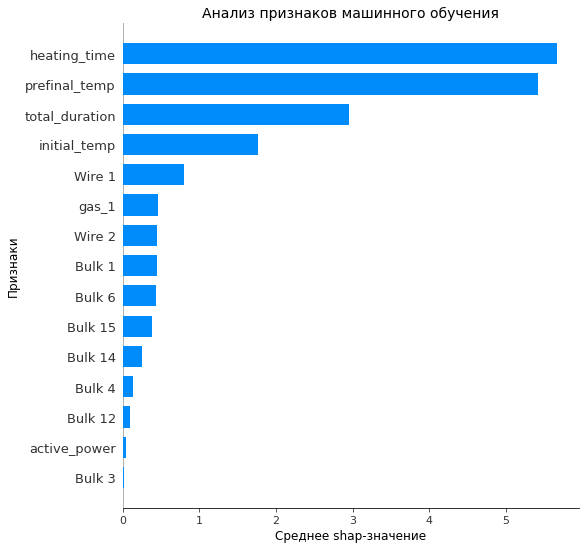

In [68]:
X_test_transformed = ridge_model.best_estimator_.named_steps['prep'].transform(X_test)

explainer = shap.LinearExplainer(model.named_steps['models'], X_test_transformed)
shap_values = explainer.shap_values(X_test_transformed)

shap.summary_plot(shap_values, X_test_transformed, feature_names=X.columns, plot_type='bar', show=False)
plt.title('Анализ признаков машинного обучения', fontsize=14)
plt.xlabel('Среднее shap-значение', fontsize=12)
plt.ylabel('Признаки', fontsize=12);

Самый большой вклад имеет время нагрева электродами. На втором месте по значимости идет температура перед финальным замером, затем время всего цикла, начальная температура, объем первого проволочного вещества. Остальные признаки имеют гораздо меньший вклад в работу модели. Проанализируем остатки:

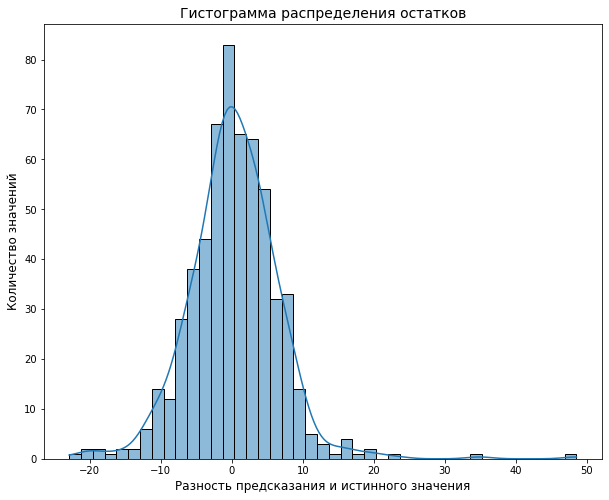

In [69]:
residuals = y_test - predictions

plt.figure(figsize=(10,8))
sns.histplot(data=residuals, kde=True)
plt.title('Гистограмма распределения остатков', fontsize=14)
plt.xlabel('Разность предсказания и истинного значения', fontsize=12)
plt.ylabel('Количество значений', fontsize=12);

С небольшой натяжкой, но остатки распределены нормально, с пиком в нуле.

<a id='res'></a>
## Итоговые выводы.

В ходе проекта решалась задача регрессии, предсказывалась температура сплава для металлургического комбината "Стальаня птица".

Данные были представлены семью датасетами, каждый из которых содержал отдельную часть от общей информации. Между собой они связывались по номеру партии металла.
- data_arc_new.csv — данные об электродах
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём)
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время)
- data_gas_new.csv — данные о продувке сплава газом
- data_temp_new.csv — результаты измерения температуры
- data_wire_new.csv — данные о проволочных материалах (объём)
- data_wire_time_new.csv — данные о проволочных материалах (время)

Вся информация была загружена, после чего предобработана и проанализирована. Датасеты были обработаны следующим образом: признаки переименованы в соответствии с правилами оформления и приведены к соответствующим типам данных, были убраны аномалии (таковыми оказались значения реактивной мощности и низкие температуры сплавов). Выбросов, если таковые наблюдались, не так много. Распределения числовых признаков походят на нормальные.

Следующим шагом проекта стал **отбор признаков для машинного обучения**. Были выделены:

Датасет **data_arc_new** :
- Активная и реактивная мощности (*active_power, reactive_power*)
- А также время начала и конца нагрева.

Датасет **data_bulk_new** : 
Отобраны объемы тех веществ, которые добавлялись чаще всего, среди таких:
- Bulk 1 (252 записи  из 3129 сущетсвующих)
- Bulk 3 (1298 записей)
- Bulk 4 (1014 записей)
- Bulk 6 (576 записей)
- Bulk 12 (2450 записей)
- Bulk 14 (2806 записей)
- Bulk 15 (2248 записей)
Остальные вещества встречались менее чем в 200 случаях, то есть менее, чем в 6% от общей массы.

Датасет **data_bulk_time_new** : материалы подавались практически мгновенно, без длительности, поэтому ценности для исследования (конкретно с такими данными) время их подачи не несет.

Датасет **data_gas_new** : была взята вся информация об объеме подаваемого газа.

Датасет **data_temp_new** : отобраны известные значения температуры и соответствующее им время.

Датасет **data_wire_new** : ситуация аналогична ситуации с сыпучими материалами, выбраны самые частые добавки:
- Wire 1 (3055 записей из 3081 всего)
- Wire 2 (1079 записей)

Датасет **data_wire_time_new** : аналогично сыпучим материалам.

После отбора признаков все они были объединены в финальный датасет **data_final**, в который также были добавлены новые:
- *heating_time* - время нагрева сплава электродами
- *total_duration* - полное время цикла
- *initial_temp*, *prefinal_temp*, *final_temp* - начальная температура, температура перед последним замером и последняя (целевой признак)
- *arc_operations_count* - количество итераций нагрева

Далее был повторно проведен **исследовательский**, а затем и корреляционный анализ итогового датасета. Вторичный исследовательский анализ не выявил ничего нового, распределения всех числовых признаков оказались в порядке (близки к нормальным), выбросов умеренное количество.

**Корреляционный анализ** выявил сильную мультиколлинеарность между активной и реактивной мощностью, также плохо себя вел признак количества итераций нагрева. Реактивная мощность была удалена, как менее значимая в физическом смысле. Количество итераций нагрева тоже было удалено из датасета, больше информации давало время нагрева электродами. Последним этапом перед подготовкой данных к машинному обучению стало удаление абсолютных времен, так как ценности для исследования они не несут.

В ходе **подготовки данных к машинному обучению** данные были разделены на выборки, созданы пайплайны по их подготовке к машинному обучению и выбраны две модели для итогового тестирования:
- Линейная модель *Ridge*, более устойчивая к выбросам, чем линейная регрессия
- Модель градиентного бустинга *CatBoostRegressor*

Для каждой из моделей подбиралось несколько гиперпараметров при помощи *RandomizedSearchCV*. 

**Машинное обучение** показало, что с данной задаче лучше и быстрее справляется линейная модель *Ridge*. Её метрика *MAE*, полученная при кросс-валидации на тренировочной выборке, составила *4.6*. Модель градиентного бустинга справлялась дольше и хуже, ее аналогичная метрика составила *7.3*. Как следствие, для дальнейших предсказаний была выбрана *Ridge*.

Выбранная модель отлично справилась с **финальным тестированием** - метрика на тестовой выборке составила *4.6*, что удовлетворяет условию поставленной задачи (*<6.8*). Анализ признаков продемонстрировал, что самый большой вклад имеет время нагрева электродами. На втором месте по значимости идет температура перед финальным замером, затем время всего цикла, начальная температура, объем первого проволочного вещества. Остальные признаки имеют гораздо меньший вклад в работу модели. Самым последним по значимости идет активная мощность. Остатки, с небольшой натяжкой, распределены нормально.

**Советы заказчику, обратить внимание на**:
- Время, затрачиваемое на нагрев сплава электродами.
- Время полного цикла.
- Объемы проволочного вещества под номером 1.